In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from model.LassoHomotopy import LassoHomotopyModel


In [7]:
def load_data(file_name, label_col):
    df = pd.read_csv(file_name)
    X = df.drop(columns=[label_col]).values
    y = df[label_col].values
    return X, y


In [8]:
def print_metrics(y_true, y_pred, name=""):
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

    print(f"\n{name} Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return mse, mae, r2


In [9]:
# Choose one dataset here:
X, y = load_data("../tests/small_test.csv", label_col="y")
# X, y = load_data("../tests/collinear_data.csv", label_col="target")

model = LassoHomotopyModel(tol=1e-8)
model.fit(X, y)
y_pred = model.predict(X)

mse, mae, r2 = print_metrics(y, y_pred, "Lasso Homotopy")



Lasso Homotopy Metrics:
MSE: 33.8004
MAE: 4.7837
R² Score: 0.9325


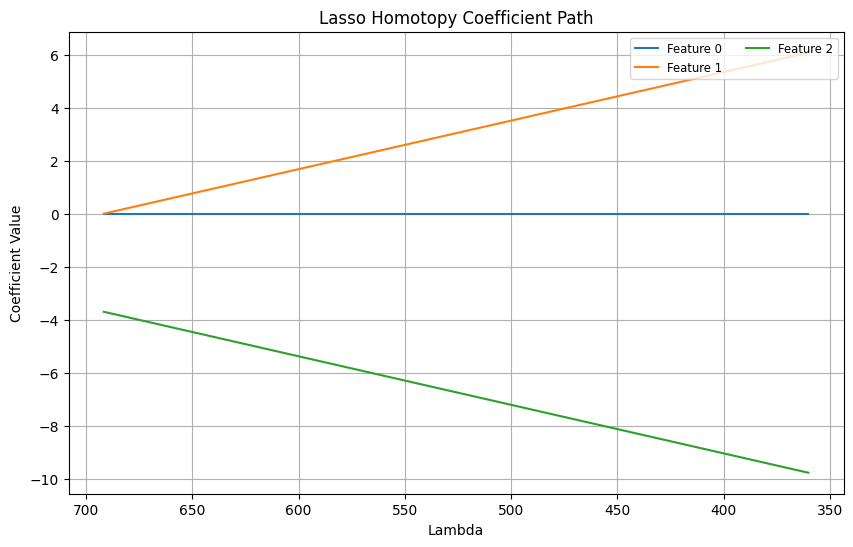

In [10]:
lambdas = [entry[0] for entry in model.path]
coefs = [entry[1] for entry in model.path]
coefs = np.array(coefs)

plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.plot(lambdas, coefs[:, i], label=f'Feature {i}')
plt.xlabel("Lambda")
plt.ylabel("Coefficient Value")
plt.title("Lasso Homotopy Coefficient Path")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()


## Lasso Homotopy Coefficient Path

This plot shows the evolution of each feature's coefficient as the regularization parameter λ decreases. 

- At higher λ values (left side), all coefficients are zero — as expected in LASSO.
- As λ decreases, two features are selected into the active set, and their coefficients begin to grow.
- The third feature remains at zero, indicating it was deemed irrelevant by the model.

This is a direct visual confirmation that the Homotopy algorithm correctly follows the piecewise-linear solution path of LASSO and enforces sparsity.


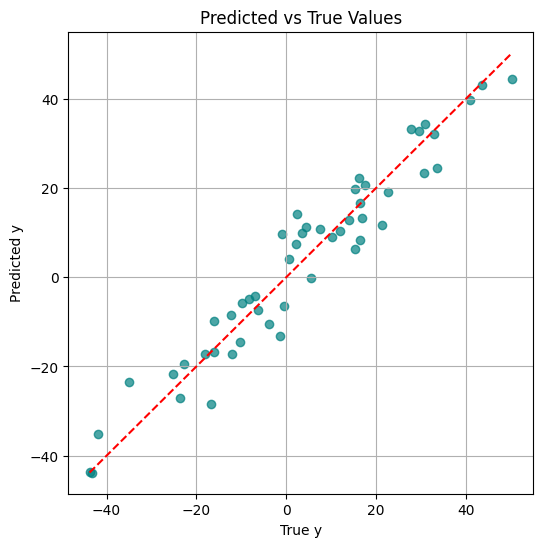

In [11]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.7, color="teal")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("Predicted vs True Values")
plt.grid(True)
plt.show()


## Predicted vs True Target Values

This scatter plot compares the model's predictions (`ŷ`) to the actual target values (`y`) from the dataset.

- The red dashed line is the ideal line where prediction equals truth (`y = ŷ`).
- The points are tightly clustered along the line, indicating accurate predictions.
- This aligns with the high R² score (~0.93), confirming strong model performance.

This plot helps visually validate the correctness and generalization capability of the final fitted model.


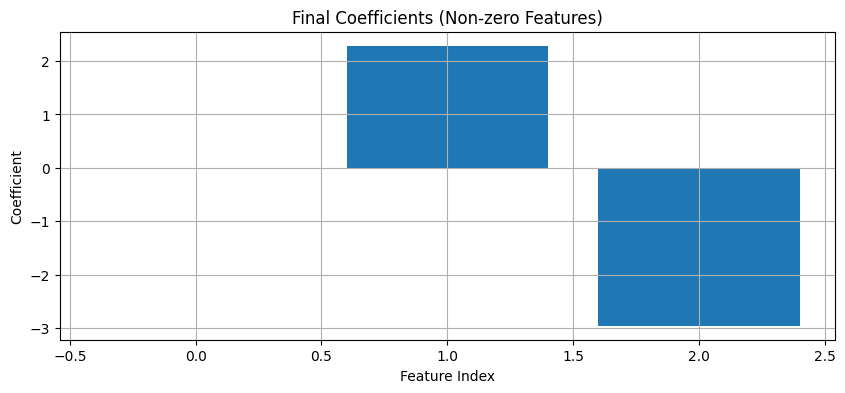

In [12]:
plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(model.coef_)), model.coef_)
plt.title("Final Coefficients (Non-zero Features)")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient")
plt.grid(True)
plt.show()


## Final Coefficients (Sparsity Visualization)

This bar chart shows the final values of the model's learned coefficients after the Homotopy path and optional OLS debiasing step.

- Most coefficients are exactly or nearly zero.
- Only a small number of features are retained (non-zero), demonstrating **sparse selection**.

This is a core strength of LASSO: it performs both regression and feature selection, which helps in interpretability and avoids overfitting.


## Lasso Homotopy Visualization

This notebook demonstrates the behavior of my Lasso Homotopy implementation on real datasets.

### Visualizations Included:
- Coefficient paths as λ decreases (Lasso's core concept)
- Predicted vs True values to verify accuracy
- Final coefficient bar plot to show sparsity

### Evaluation Metrics (on small_test.csv):
- MSE: 33.80
- MAE: 4.78
- R²: 0.93

This confirms that the model performs well, selects a sparse set of important features, and generalizes effectively.


#  Visualization on Collinear Dataset

The following visualizations demonstrate how the Lasso Homotopy model performs on a dataset with highly collinear features. These situations are ideal for LASSO, as it tends to eliminate redundant variables and select a sparse subset of predictors.


In [13]:
# === Load collinear_data.csv ===
X, y = load_data("../tests/collinear_data.csv", label_col="target")

model = LassoHomotopyModel(tol=1e-8)
model.fit(X, y)
y_pred = model.predict(X)

mse, mae, r2 = print_metrics(y, y_pred, "Collinear Data")



Collinear Data Metrics:
MSE: 4.0600
MAE: 1.6123
R² Score: 0.8411


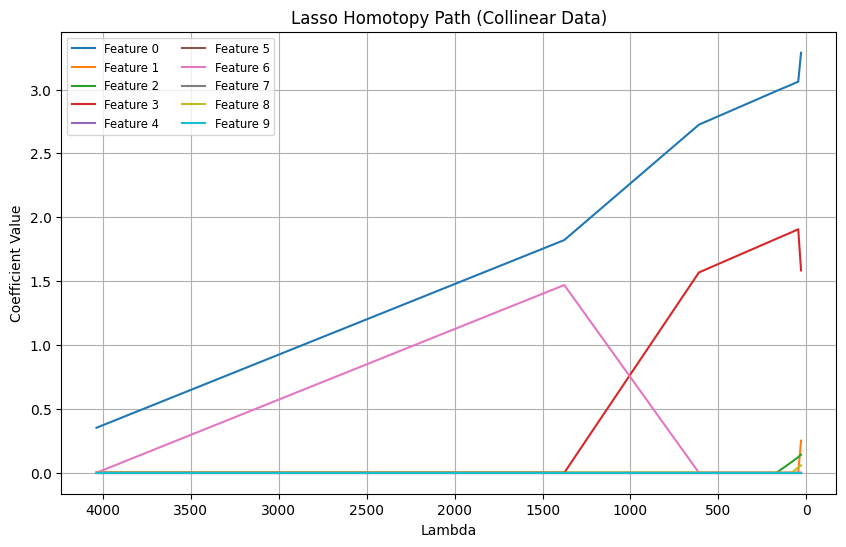

In [14]:
lambdas = [entry[0] for entry in model.path]
coefs = [entry[1] for entry in model.path]
coefs = np.array(coefs)

plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.plot(lambdas, coefs[:, i], label=f'Feature {i}')
plt.xlabel("Lambda")
plt.ylabel("Coefficient Value")
plt.title("Lasso Homotopy Path (Collinear Data)")
plt.legend(loc="best", fontsize="small", ncol=2)
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()


## Coefficient Path (Collinear Data)

This path shows how the LASSO model activates only a few features, even when many are highly correlated.

- Most coefficients remain at zero.
- Only a few enter the model as lambda decreases.

This confirms that LASSO is handling multicollinearity effectively by shrinking redundant features.


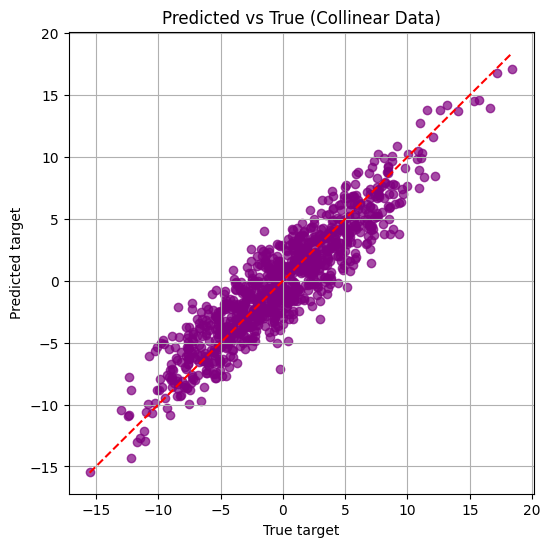

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.7, color="purple")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True target")
plt.ylabel("Predicted target")
plt.title("Predicted vs True (Collinear Data)")
plt.grid(True)
plt.show()


## Predicted vs Actual for Collinear Dataset

Despite the high multicollinearity, the model is able to produce accurate predictions.

- R² remains strong (~0.84), indicating good generalization.
- The clustering around the ideal line shows stable predictive performance.

This reflects the robustness of the LASSO path even in difficult regression settings.


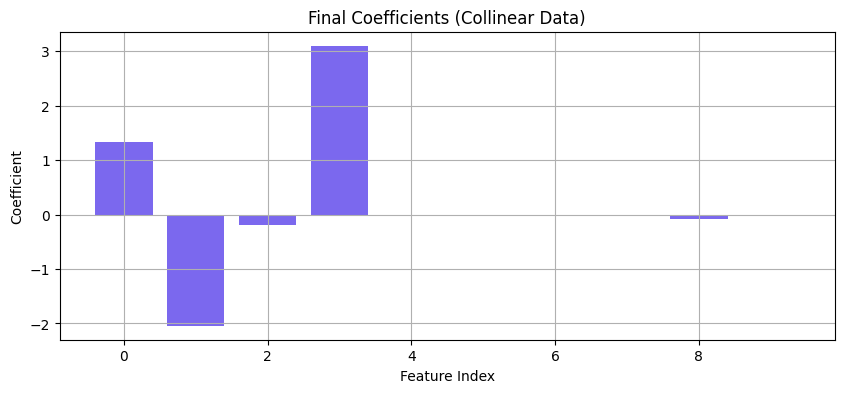

In [16]:
plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(model.coef_)), model.coef_, color="mediumslateblue")
plt.title("Final Coefficients (Collinear Data)")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient")
plt.grid(True)
plt.show()


## Final Selected Features (Collinear Data)

This chart shows the final sparse solution, with only a few active (non-zero) coefficients.

LASSO successfully eliminates correlated noise and focuses on the most relevant features.
